In [ ]:
#link for the datasets: https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/data/

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer,MaxAbsScaler
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.feature_extraction.text import HashingVectorizer

In [ ]:
training_data = pd.read_csv("C:/Users/USER/Desktop/school_budgeting/TrainingData.csv",index_col=0)

In [6]:
training_data.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,...,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,...,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,...,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,...,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


In [4]:
#descriptive statistics

In [7]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Function                400277 non-null  object 
 1   Use                     400277 non-null  object 
 2   Sharing                 400277 non-null  object 
 3   Reporting               400277 non-null  object 
 4   Student_Type            400277 non-null  object 
 5   Position_Type           400277 non-null  object 
 6   Object_Type             400277 non-null  object 
 7   Pre_K                   400277 non-null  object 
 8   Operating_Status        400277 non-null  object 
 9   Object_Description      375493 non-null  object 
 10  Text_2                  88217 non-null   object 
 11  SubFund_Description     306855 non-null  object 
 12  Job_Title_Description   292743 non-null  object 
 13  Text_3                  109152 non-null  object 
 14  Text_4         

In [8]:
training_data.describe()

,FTE,Total
count,126071.000000,3.957220e+05
mean,0.426794,1.310586e+04
std,0.573576,3.682254e+05
min,-0.087551,-8.746631e+07
25%,0.000792,7.379770e+01
50%,0.130927,4.612300e+02
75%,1.000000,3.652662e+03
max,46.800000,1.297000e+08


In [9]:
#EDA

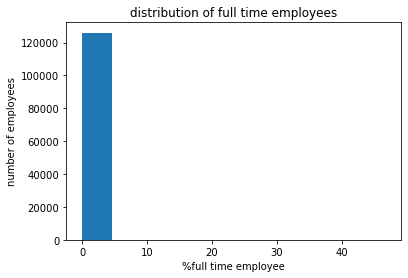

In [10]:
plt.hist(training_data['FTE'].dropna())
plt.title("distribution of full time employees")
plt.xlabel("%full time employee")
plt.ylabel("number of employees")
plt.show()

In [9]:
#% of full time employee is bimodal

In [11]:
training_data.dtypes.value_counts()

object     23
float64     2
dtype: int64

In [12]:
#convert the object data type to categorical
Labels = ['Function','Use','Sharing','Reporting','Student_Type','Position_Type','Object_Type','Pre_K']

In [12]:
#Labels = [i for i in training_data.columns[training_data.dtypes == 'object']]

In [13]:
categorize_labels = lambda x: x.astype('category')
training_data[Labels] = training_data[Labels].apply(categorize_labels,axis=0)
#print(training_data[Labels].dtypes)

In [14]:
num_unique_labels = training_data[Labels].apply(pd.Series.nunique)

In [15]:
num_unique_labels

Function         37
Use               8
Sharing           5
Reporting         3
Student_Type      9
Position_Type    25
Object_Type      11
Pre_K             3
dtype: int64

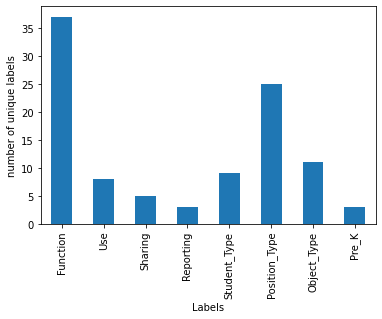

In [16]:
num_unique_labels.plot(kind='bar')
plt.xlabel("Labels")
plt.ylabel("number of unique labels")
plt.show()

In [17]:
#logloss = y*log(p) + (1-y)log(1-p)

In [17]:
def log_loss(predicted,actual,eps=1e-14):
    """
    takes input as `predicted` and `actual` values and returns the loss of the model
    """
    predicted = np.clip(predicted, eps, 1-eps)
    loss = -1*np.mean(actual*np.log(predicted)+(1-actual)*np.log(1-predicted))
    return loss

In [18]:
log_loss(1,0.85),log_loss(0,0.99),log_loss(0,0.51)

(4.835548634902035, 31.913829388897476, 16.44045756397749)

In [19]:
def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).any():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])

In [21]:
#build a model

In [20]:
numeric_columns = ['FTE','Total']

In [23]:
numeric_columns_data = training_data[numeric_columns].fillna(-1000)

In [30]:
holdout = pd.read_csv("C:/Users/USER/Desktop/school_budgeting/TestData.csv",index_col=0)

C:\Users\USER\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [31]:
#prediction = clf.predict_proba(holdout[numeric_columns].fillna(-1000))

In [32]:
#prediction_df = pd.DataFrame(columns=pd.get_dummies(training_data[Labels]).columns,index=holdout.index,data=prediction)

In [33]:
#prediction_df

In [34]:
#prediction_df.to_csv("C:/Users/USER/Desktop/school_budgeting/predictions.csv")

In [35]:
#NLP 

In [36]:
#tokens_alphanum = '[A-Za-z0-9]+(?=\\s+)'

In [37]:
#training_data.Position_Extra.fillna(" ",inplace=True)

In [38]:
#vec_count = CountVectorizer(token_pattern=tokens_alphanum)

In [39]:
#vec_count.fit(training_data.Position_Extra)

In [40]:
#msg = "There are {} tokens in Position_Extra if we split on non-alpha numeric"
#print(msg.format(len(vec_count.get_feature_names())))
#print(vec_count.get_feature_names()[:15])

In [21]:
def combine_text_to_columns(dataframe,to_drop=numeric_columns +  Labels):
    """
    combining the columns by dropping numeric and labels and generating 
    the single text vector
    """
    to_drop = set(to_drop) & set(dataframe.columns.tolist())
    text_data = dataframe.drop(to_drop,axis=1)
    text_data.fillna("",inplace=True)
    return text_data.apply(lambda x: " ".join(x),axis=1)

In [52]:
#combine_text_to_columns(training_data,to_drop=numeric_columns + Labels)

In [113]:
"""
#getting the text vector and transforming to get basic and alpha-numeric tokens
"""
token_basic = '\\S+(?=\\s+)'
token_alphanum = '[A-Za-z0-9]+(?=\\s+)'
vec_basic = CountVectorizer(token_pattern=token_basic)
vec_alphanum = CountVectorizer(token_pattern=token_alphanum)
text_vector = combine_text_to_columns(training_data)
vec_basic.fit_transform(text_vector)
print("there are {} tokens in dataset".format(len(vec_basic.get_feature_names())))
vec_alphanum.fit_transform(text_vector)
print("there are {} alpha-numeric tokens in the dataset".format(len(vec_alphanum.get_feature_names())))

there are 4760 tokens in dataset
there are 3284 alpha-numeric tokens in the dataset


In [43]:
#create a pipeline with LogisticRegression

In [22]:
dummy_labels = pd.get_dummies(training_data[Labels])

In [23]:
non_labels = [c for c in training_data.columns if c not in Labels]

In [87]:
X_train, X_test, Y_train, Y_test = multilabel_train_test_split(training_data[numeric_columns],dummy_labels,0.2,seed=123)

In [88]:
pl = Pipeline([
    ('imputer',SimpleImputer()),
    ('clf',OneVsRestClassifier(LogisticRegression()))
    
])

In [89]:
pl.fit(X_train,Y_train)

Pipeline(steps=[('imputer', SimpleImputer()),
                ('clf', OneVsRestClassifier(estimator=LogisticRegression()))])

In [90]:
pl.score(X_train,Y_train)

0.0

In [101]:
pl.score(X_test,Y_test)

0.0

In [69]:
dummy_labels2 = pd.get_dummies(training_data[Labels])

In [70]:
non_labels = [c for c in training_data.columns if c not in Labels]

In [102]:
X_train2, X_test2, Y_train2, Y_test2 = multilabel_train_test_split(training_data[non_labels],dummy_labels,0.2,seed=123)

In [103]:
get_text_data = FunctionTransformer(combine_text_to_columns,validate=False)

In [104]:
get_numeric_data = FunctionTransformer(lambda x:x[numeric_columns],validate=False)

In [84]:
pl2 = Pipeline(steps=[
    ('union',FeatureUnion(
    transformer_list= [
        
        ('numeric_features',Pipeline([
            
            ('selector',get_numeric_data),
            ('imputer',SimpleImputer())
            
        ])),
        
        ('text_features',Pipeline([
            
            ('selector',get_text_data),
            ('vectorizer',CountVectorizer())
        ]))
    ]
    
    
    )),
    
    ('clf',OneVsRestClassifier(LogisticRegression(max_iter=10000)))
    
])

In [85]:
pl2.fit(X_train2,Y_train2)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x0000025F516B2B80>)),
                                                                 ('imputer',
                                                                  SimpleImputer())])),
                                                ('text_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function combine_text_to_columns at 0x0000025F29421EE0>)),
                                                                 ('vectorizer',
                                                                  CountVectorizer())]))])),
                ('clf',
                 OneVsRestClassifier

In [86]:
pl2.score(X_train,Y_train)

2.4982668273884993e-05

In [105]:
"""
#create a pipeline with RandomForestClassifier 
"""

In [94]:
pl3 = Pipeline([
    ('union',FeatureUnion(
    transformer_list= [
        ('numeric_features',Pipeline([
           
            ('selector',get_numeric_data), 
            ('imputer',SimpleImputer())
            
        ])),
        
        ('text_features',Pipeline([
            
            ('selector',get_text_data),
            ('vectorizer',CountVectorizer())
        ]))
        
        
    ]
    
    )),
    
    ('clf',OneVsRestClassifier(RandomForestClassifier(n_estimators=7600)))
    
])

In [97]:
dummy_labels3 = pd.get_dummies(training_data[Labels])

In [98]:
non_labels3 = [c for c in training_data.columns if c not in Labels]

In [99]:
X_train3, X_test3, Y_train3, Y_test3 = multilabel_train_test_split(training_data[non_labels3],dummy_labels3,0.2,seed=123)

In [ ]:
pl3.fit(X_test3,Y_test3)

In [106]:
#make the model even better by using ngrams and scaling

In [107]:
dummy_labels4 = pd.get_dummies(training_data[Labels])

In [108]:
non_labels4 = [c for c in training_data.columns if c not in Labels]

In [116]:
X_train4, X_test4, Y_train4, Y_test4 = multilabel_train_test_split(training_data[non_labels4],dummy_labels4,0.2,seed=123)

In [124]:
"""
#300 best features are selected and pipeline is built
"""
pl4 = Pipeline([
    ('union',FeatureUnion(
    transformer_list= [
        ('numeric_features',Pipeline([
           
            ('selector',get_numeric_data), 
            ('imputer',SimpleImputer())
            
        ])),
        
        ('text_features',Pipeline([
            
            ('selector',get_text_data),
            ('vectorizer',CountVectorizer(token_pattern=token_alphanum,ngram_range=(1,2))),
            ('dim_red',SelectKBest(chi2,k=300))
        ]))
        
        
    ]
    
    )),
    
    ('scale',MaxAbsScaler()),
    ('clf',OneVsRestClassifier(LogisticRegression(max_iter=10000)))
    
])

In [125]:
pl4.fit(X_train4,Y_train4)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x0000025F10BFFC10>)),
                                                                 ('imputer',
                                                                  SimpleImputer())])),
                                                ('text_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function combine_text_to_columns at 0x0000025F29421EE0>)),
                                                                 ('vectorizer',
                                                                  CountVectorizer(ngram_range=(1,
                                                      

In [128]:
pl4.score(X_train4,Y_train4)

0.6385351412457607

In [129]:
pl4.score(X_test4,Y_test4)

0.6369620885641122

In [126]:
"""
sparse-interaction() has been implemented to improve the model accuracy

"""

In [130]:
dummy_labels5 = pd.get_dummies(training_data[Labels])

In [131]:
non_labels5 = [c for c in training_data.columns if c not in Labels]

In [132]:
X_train5, X_test5, Y_train5, Y_test5 = multilabel_train_test_split(training_data[non_labels5],dummy_labels5,0.2,seed=123)

In [133]:
from itertools import combinations

import numpy as np
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin


class SparseInteractions(BaseEstimator, TransformerMixin):
    def __init__(self, degree=2, feature_name_separator="_"):
        self.degree = degree
        self.feature_name_separator = feature_name_separator

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not sparse.isspmatrix_csc(X):
            X = sparse.csc_matrix(X)

        if hasattr(X, "columns"):
            self.orig_col_names = X.columns
        else:
            self.orig_col_names = np.array([str(i) for i in range(X.shape[1])])

        spi = self._create_sparse_interactions(X)
        return spi

    def get_feature_names(self):
        return self.feature_names

    def _create_sparse_interactions(self, X):
        out_mat = []
        self.feature_names = self.orig_col_names.tolist()

        for sub_degree in range(2, self.degree + 1):
            for col_ixs in combinations(range(X.shape[1]), sub_degree):
                # add name for new column
                name = self.feature_name_separator.join(self.orig_col_names[list(col_ixs)])
                self.feature_names.append(name)

                # get column multiplications value
                out = X[:, col_ixs[0]]
                for j in col_ixs[1:]:
                    out = out.multiply(X[:, j])

                out_mat.append(out)

        return sparse.hstack([X] + out_mat)

In [134]:
pl5 = Pipeline([
    ('union',FeatureUnion(
    transformer_list= [
        ('numeric_features',Pipeline([
           
            ('selector',get_numeric_data), 
            ('imputer',SimpleImputer())
            
        ])),
        
        ('text_features',Pipeline([
            
            ('selector',get_text_data),
            ('vectorizer',CountVectorizer(token_pattern=token_alphanum,ngram_range=(1,2))),
            ('dim_red',SelectKBest(chi2,k=300))
        ]))
        
        
    ]
    
    )),
    ('int',SparseInteractions(degree=2)),
    ('scale',MaxAbsScaler()),
    ('clf',OneVsRestClassifier(LogisticRegression(max_iter=10000)))
    
])

In [136]:
#pl5.fit(X_train5,Y_train5)

In [138]:
"""
hashing to reduce the computational expenses
hence it has been used in the Machine learning pipeline.

"""

In [139]:
dummy_labels6 = pd.get_dummies(training_data[Labels])

In [141]:
non_labels6 = [c for c in training_data.columns if c not in Labels]

In [142]:
X_train6, X_test6, Y_train6, Y_test6 = multilabel_train_test_split(training_data[non_labels6],dummy_labels6,0.2,seed=123)

In [162]:
pl6 = Pipeline([
    ('union',FeatureUnion(
    transformer_list= [
        ('numeric_features',Pipeline([
           
            ('selector',get_numeric_data), 
            ('imputer',SimpleImputer())
            
        ])),
        
        ('text_features',Pipeline([
            
            ('selector',get_text_data),
            ('vectorizer',HashingVectorizer(token_pattern=token_alphanum,alternate_sign=False,norm=None,binary=False,ngram_range=(1,2))),
            ('dim_red',SelectKBest(chi2,k=300))
            
        ]))
        
        
    ]
    
    )),
    #takes too long to run due to lack of computational power('int',SparseInteractions(degree=2)),
    #reason , it creates long a sparse matrix for the n_grams
    ('scale',MaxAbsScaler()),
    ('clf',OneVsRestClassifier(LogisticRegression(max_iter=10000)))
    
])

In [159]:
pl6.fit(X_train6,Y_train6)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x0000025F10BFFC10>)),
                                                                 ('imputer',
                                                                  SimpleImputer())])),
                                                ('text_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function combine_text_to_columns at 0x0000025F29421EE0>)),
                                                                 ('vectorizer',
                                                                  HashingVectorizer(alternate_sign=False,
                                              

In [160]:
pl6.score(X_train6,Y_train6)

0.6385757380817059

In [161]:
pl6.score(X_test6,Y_test6)

0.6370245456248829